# NIRS (model)

In [1]:
import utils as utils
import torch
import numpy as np
import pandas as pd
import icecream as ic
import matplotlib.pyplot as plt
import seaborn as sns

utils.seed_everything(42)

%matplotlib inline
sns.set_style('darkgrid')

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Init and reading data

In [2]:
df = pd.read_csv('data/merged_data_processed.csv')
unreviewed_products_df = pd.read_csv('data/unreviewed_products_processed.csv')
products_df = pd.read_csv('data/products_sampled_processed.csv')
reviews_df = pd.read_csv('data/reviews_sampled_processed.csv')

In [3]:
print(f'Shape of df: {df.shape}')
print(f'Shape of unreviewed_products_df: {unreviewed_products_df.shape}')
print(f'Shape of products_df: {products_df.shape}')
print(f'Shape of reviews_df: {reviews_df.shape}')

Shape of df: (47260, 49)
Shape of unreviewed_products_df: (22900, 42)
Shape of products_df: (35246, 42)
Shape of reviews_df: (45489, 8)


In [4]:
print(f'Number of unique products: {products_df["asin"].nunique()}')
print(f'Number of unique users: {reviews_df["reviewerID"].nunique()}')
print(f'Number of unique reviewed products: {df["asin"].nunique()}')
print(f'Number of unique unreviewed products: {unreviewed_products_df["asin"].nunique()}')

Number of unique products: 34211
Number of unique users: 1000
Number of unique reviewed products: 11372
Number of unique unreviewed products: 22839


## Other data preparation for the model

### User and product id mapping

In [13]:
# Create user and item mappings
user_mapping = {user_id: index for index, user_id in enumerate(df['reviewerID'].unique())}
item_mapping = {item_id: index for index, item_id in enumerate(products_df['asin'].unique())}

reviewed_item_mapping = {item_id: index for index, item_id in enumerate(df['asin'].unique())}

# Map user and item IDs to indices
df['user_index'] = df['reviewerID'].map(user_mapping)
df['item_index'] = df['asin'].map(reviewed_item_mapping)

### User-item matrix

In [54]:
user_product_matrix = pd.pivot_table(df, values='overall', index='reviewerID', columns='asin', fill_value=0)

### Text Embeddings (with Word2Vec or whatever)

In [55]:
from gensim.models import Word2Vec

# Create embeddings using Word2Vec
def create_word2vec_embeddings(texts, embedding_dim):
  # Tokenize the texts
  tokenized_texts = [text.split() for text in texts]
  
  # Train Word2Vec model
  model = Word2Vec(tokenized_texts, vector_size=embedding_dim, window=5, min_count=1, workers=4)
  
  # Get the embeddings for each text
  embeddings = []
  for text in tokenized_texts:
      embedding = np.mean([model.wv[word] for word in text if word in model.wv], axis=0)
      embeddings.append(embedding)
  
  return np.array(embeddings)

In [56]:
df_reviewed_products = products_df[products_df['asin'].isin(df['asin'].unique())].drop_duplicates(subset=['asin'])
df_reviewed_products['brand'] = df_reviewed_products['brand'].astype(str)
df['brand'] = df['brand'].astype(str)

In [106]:
# Create embeddings for textual data
reviewTexts_embs = torch.tensor(create_word2vec_embeddings(df['reviewText'], embedding_dim=200))
summary_embs = torch.tensor(create_word2vec_embeddings(df['summary'], embedding_dim=200))
title_embs = torch.tensor(create_word2vec_embeddings(df['title'], embedding_dim=200))
description_embs = torch.tensor(create_word2vec_embeddings(df['description'], embedding_dim=200))
feature_embs = torch.tensor(create_word2vec_embeddings(df['feature'], embedding_dim=200))
brand_embs = torch.tensor(create_word2vec_embeddings(df['brand'], embedding_dim=200))

#load the embeddings
# review_embeddings = torch.load('data/embeds/review_embeddings.pt')
# summary_embeddings = torch.load('data/embeds/summary_embeddings.pt')
# description_embeddings = torch.load('data/embeds/description_embeddings.pt')
# title_embeddings = torch.load('data/embeds/title_embeddings.pt')
# feature_embeddings = torch.load('data/embeds/feature_embeddings.pt')

ic| reviewTexts_embs.shape: torch.Size([47260, 200])
    summary_embs.shape: torch.Size([47260, 200])
    title_embs.shape: torch.Size([47260, 200])
    description_embs.shape: torch.Size([47260, 200])
    feature_embs.shape: torch.Size([47260, 200])
    brand_embs.shape: torch.Size([47260, 200])


(torch.Size([47260, 200]),
 torch.Size([47260, 200]),
 torch.Size([47260, 200]),
 torch.Size([47260, 200]),
 torch.Size([47260, 200]),
 torch.Size([47260, 200]))

In [107]:
# review (user) embeddings by taking the mean of the review-related embeddings
reviews_text_embs = torch.mean(torch.stack([reviewTexts_embs, summary_embs]), dim=0)

# item embeddings by taking the mean of the item-related embeddings
items_text_embs = torch.mean(torch.stack([title_embs, description_embs, feature_embs, brand_embs]), dim=0)

ic| reviews_text_embs.shape: torch.Size([47260, 200])
    items_text_embs.shape: torch.Size([47260, 200])


(torch.Size([47260, 200]), torch.Size([47260, 200]))

In [108]:
reviews_text_embs.shape, items_text_embs.shape

(torch.Size([47260, 200]), torch.Size([47260, 200]))

### Embed (SVD) from user-matrix pivot table

In [109]:
def SVD_embeddings(user_item_matrix: pd.DataFrame, embedding_length):
    """
    Apply SVD to the user-item matrix to obtain user and item embeddings.
    U = m x r orthogonal left singular matrix, which represents the relationship between users and latent factors
    S = r x r diagonal matrix, which describes the strength of each latent factor
    V = r x n diagonal right singular matrix, which indicates the similarity between items and latent factors
    
    :param user_item_matrix: user-item matrix
    :param embedding_length: number of latent factors, which is the dimensionality of the reduced space
    """
    from scipy.sparse.linalg import svds
    
    # transpose the matrix to obtain the item-user matrix
    # (this due to the large number of items compared to users)
    matrix = user_item_matrix.values

    U, Sigma, VT = svds(matrix, k=embedding_length)
    user_embed_df = pd.DataFrame(U, index = user_item_matrix.index)
    VT_T = np.transpose(VT)
    item_embed_df = pd.DataFrame(VT_T, index=user_item_matrix.columns)
    
    return user_embed_df, item_embed_df

In [110]:
user_embed_df, item_embed_df = SVD_embeddings(user_product_matrix, 800)

## Model

### DataLoaders for the Pytorch-based model

In [111]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader 

# class for the dataset
class AmazonReviewDataset(Dataset):
    def __init__(self, user_ids, product_ids, ratings, reviews_text_data, product_text_data):
        self.user_ids = user_ids
        self.product_ids = product_ids
        self.ratings = ratings
        self.reviews_text_data = reviews_text_data
        self.product_text_data = product_text_data

    def __len__(self):
        return len(self.user_ids)

    def __getitem__(self, index):
        user_id = self.user_ids[index]
        item_id = self.product_ids[index]
        rating = self.ratings[index]
        review_text_data = self.reviews_text_data[index]
        item_text_data = self.product_text_data[index]
        
        return user_id, item_id, rating, review_text_data, item_text_data

# Split the data into train and test sets
train_data, test_data = train_test_split(df, test_size=0.2, random_state=42)

# Create train and test datasets
train_dataset = AmazonReviewDataset(
    train_data['user_index'].values,
    train_data['item_index'].values,
    train_data['overall'].values,
    reviews_text_embs[train_data.index],
    items_text_embs[train_data.index]
)

test_dataset = AmazonReviewDataset(
    test_data['user_index'].values,
    test_data['item_index'].values,
    test_data['overall'].values,
    reviews_text_embs[test_data.index],
    items_text_embs[test_data.index]
)

### Vanilla SVD

In [112]:
# predictions with the the obrained SVD embeddings
def predict_ratings(user_embed_df: pd.DataFrame, item_embed_df: pd.DataFrame, user_id: str, item_id: str):
    """
    Predict the rating for a given user and item.
    
    :param user_embed_df: user embeddings
    :param item_embed_df: item embeddings
    :param user_id: user id
    :param item_id: item id
    """
    user_embedding = user_embed_df.loc[user_id]
    item_embedding = item_embed_df.loc[item_id]
    
    
    rating = np.dot(user_embedding, item_embedding)
    return rating

# example of prediction with a an item rated by a user
user_id = user_product_matrix.index[0]

# take the first product id rated by "user_id"
# (thus an element that is not 0 in the user-product matrix)
item_id = user_product_matrix.columns[user_product_matrix.loc[user_id] != 0].values[0]

print(f'Predicted rating for user {user_id} and item {item_id}: {predict_ratings(user_embed_df, item_embed_df, user_id, item_id)}')

Predicted rating for user A100WO06OQR8BQ and item B000034DLQ: 0.033726150835927886


In [113]:
# see if the predictions are consistent with the actual ratings
actual_rating = user_product_matrix.loc[user_id, item_id]

actual_rating

1.0

### Quick model test with SVD from scikit-surprise

Quick performance check of SVD by using scikit-surprise:

In [114]:
from surprise import BaselineOnly, Dataset, SVD, Reader, accuracy, Trainset
from surprise.model_selection import cross_validate, train_test_split, KFold

# A reader is still needed but only the rating_scale param is requiered.
reader = Reader(rating_scale=(1, 5))

# The columns must correspond to user id, item id and ratings (in that order).
data_test = Dataset.load_from_df(df[["reviewerID", "asin", "overall"]], reader)

# sample random trainset and testset
# test set is made of 25% of the ratings.
trainset, testset = train_test_split(data_test, test_size=0.25)

# define a cross-validation iterator
kf = KFold(n_splits=5)

algo = SVD()

for trainset, testset in kf.split(data_test):

    # train and test algorithm.
    algo.fit(trainset)
    predictions = algo.test(testset)

    # Compute and print Root Mean Squared Error
    accuracy.rmse(predictions, verbose=True)

RMSE: 0.7126
RMSE: 0.7033
RMSE: 0.7071
RMSE: 0.7142
RMSE: 0.7129


In [115]:
user_id = 'A1HBTW5M7ZZ9PT'
test_user = reviews_df[reviews_df['reviewerID'] == user_id]
item_id = 'B00006IEI7'

In [116]:
# get a prediction for specific users and items.
pred = algo.predict(user_id, item_id, r_ui=5, verbose=True)

user: A1HBTW5M7ZZ9PT item: B00006IEI7 r_ui = 5.00   est = 4.77   {'was_impossible': False}


### Neural Collaborative Filtering

In [117]:
from torch import nn
from icecream import ic

class NCF(nn.Module):
    def __init__(self, num_users, num_items, embedding_dim, text_embedding_dims, dropout_rate_fc=0.2):
        super(NCF, self).__init__()
        
        
        # embedding layers for the users and items ids (GMF part)
        self.user_embedding = nn.Embedding(num_users, embedding_dim)
        self.item_embedding = nn.Embedding(num_items, embedding_dim)
        
        # Additional input layers for each type of text embedding
        # (the text embeddings will be passed through an additional 
        # linear layer (text_embedding_layer) to project them into 
        # the same embedding space as the user and item embeddings)
        # self.text_embedding_layers = nn.ModuleList()
        # for text_embedding_dim in text_embedding_dims:
        #     self.text_embedding_layers.append(nn.Linear(text_embedding_dim, embedding_dim))
            
        # MLP part
        # input_dim = embedding_dim * (2 + len(text_embedding_dims)) # user, item, and text embeddings
        input_dim = embedding_dim * 2 # user and item embeddings
        self.fc_layers = nn.Sequential(
            nn.Linear(input_dim, 1024),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate_fc),
            nn.BatchNorm1d(1024),
            
            nn.Linear(1024, 256),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate_fc),
            nn.BatchNorm1d(256),
            
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate_fc),
            nn.BatchNorm1d(128),
            
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Dropout(p=dropout_rate_fc),
            nn.BatchNorm1d(64),
            
            nn.Linear(64, 32),
            nn.ReLU(),
            
            nn.Linear(32, 16),
            nn.ReLU(),
        )
        
        # NCF layer (the layer one at the end!)
        self.output_layer = nn.Linear(16, 1)

    def forward(self, user_ids, item_ids, text_embeddings):
        user_embeddings = self.user_embedding(user_ids)
        item_embeddings = self.item_embedding(item_ids)
                
        # Project each type of text embedding to the same embedding space
        text_embs = []
        # for i, text_embedding in enumerate(text_embeddings):
        #     text_emb = self.text_embedding_layers[i](text_embedding)
        #     text_embs.append(text_emb)
        
        # element-wise product
        # x = torch.cat([user_embeddings, item_embeddings, *text_embs], dim=1)
        x = torch.cat([user_embeddings, item_embeddings], dim=1)
        
        x = self.fc_layers(x)
        output = self.output_layer(x)
        return output

#### Training and evaluating - related functions

In [118]:
# Train the NCF model
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tqdm import tqdm

class RMSELoss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.mse = nn.MSELoss()
        self.eps = eps
        
    def forward(self,yhat,y):
        loss = torch.sqrt(self.mse(yhat,y) + self.eps)
        return loss

def train_model(model: NCF, train_dataloader: AmazonReviewDataset, valid_dataloader: AmazonReviewDataset, criterion, optimizer, device, num_epochs):
    train_loss_history = []
    valid_loss_history = []
    
    model.train()
    for epoch in range(num_epochs):
        running_loss = 0.0
        valid_loss = 0.0
        progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch")
        for user_ids, item_ids, rating, r_text_embeds, p_text_embeds in progress_bar:
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            r_text_embeds = r_text_embeds.to(device)
            p_text_embeds = p_text_embeds.to(device)

            optimizer.zero_grad()
            outputs = model(user_ids, item_ids, [r_text_embeds, p_text_embeds])
            loss = criterion(outputs.squeeze(), rating.float())
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix(train_loss=np.sqrt(running_loss / len(progress_bar)))

        # Calculate validation loss
        valid_loss, _ = evaluate_model(model, valid_dataloader, criterion, device)
        
        train_loss_history.append(running_loss / len(progress_bar))
        valid_loss_history.append(valid_loss)
        print('\n')
        
    return train_loss_history, valid_loss_history
        
# Evaluate the NCF model
def evaluate_model(model, dataloader, criterion, device):
    model.eval()
    predictions = []
    true_ratings = []
    running_loss = 0.0
    
    with torch.no_grad():
        progress_bar = tqdm(dataloader, desc="Evaluating", unit="batch")
        for user_ids, item_ids, rating, r_text_embeds, p_text_embeds in progress_bar:
            user_ids = user_ids.to(device)
            item_ids = item_ids.to(device)
            r_text_embeds = r_text_embeds.to(device)
            p_text_embeds = p_text_embeds.to(device)
            
            outputs = model(user_ids, item_ids, [r_text_embeds, p_text_embeds])
            predictions.extend(outputs.squeeze().tolist())
            true_ratings.extend(rating.tolist())
            
            running_loss += criterion(outputs.squeeze(), rating.float()).item()
            progress_bar.set_postfix(eval_loss=np.sqrt(running_loss / len(progress_bar)))

    mse = mean_squared_error(true_ratings, predictions)
    mae = mean_absolute_error(true_ratings, predictions)
    return mse, mae


def plot_accuracy(train_acc_history, val_acc_history, loss_name='MSE'):
  df = pd.DataFrame({'Epoch': range(1, len(train_acc_history)+1),
             'Train Accuracy': train_acc_history,
             'Validation Accuracy': val_acc_history})

  plt.figure(figsize=(10, 6))
  sns.lineplot(data=df, x='Epoch', y='Train Accuracy', label=f'Train loss ({loss_name})')
  sns.lineplot(data=df, x='Epoch', y='Validation Accuracy', label=f'Validation loss ({loss_name})')
  plt.xlabel('Epoch')
  plt.ylabel(loss_name)
  plt.title(f'Training and Validation loss {loss_name}')
  plt.legend()
  plt.show()

#### Model training

In [119]:
import torch.optim as optim
import torch.nn as nn

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Create the NCF model
num_users = len(user_mapping)
num_items = len(reviewed_item_mapping)
embedding_dim = 200
droput_rate_fc = 0.1
text_embedding_dims = [emb.shape[1] for emb in [reviews_text_embs, items_text_embs]]

model = NCF(
  num_users, num_items, embedding_dim, text_embedding_dims, droput_rate_fc).to(device)

# Define loss function (MSE) and optimizer
criterion = RMSELoss()
# criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 20
print('Loss criterion: RMSE\n')
train_loss_history, val_loss_history =  train_model(model, train_loader, test_loader, criterion, optimizer, device, num_epochs)

Loss criterion: RMSE



Epoch 1/20:   7%|▋         | 20/296 [00:00<00:04, 60.92batch/s, train_loss=0.526]

Evaluating:   0%|          | 0/74 [00:00<?, ?batch/s]


IndexError: index 11006 is out of bounds for dimension 0 with size 9452

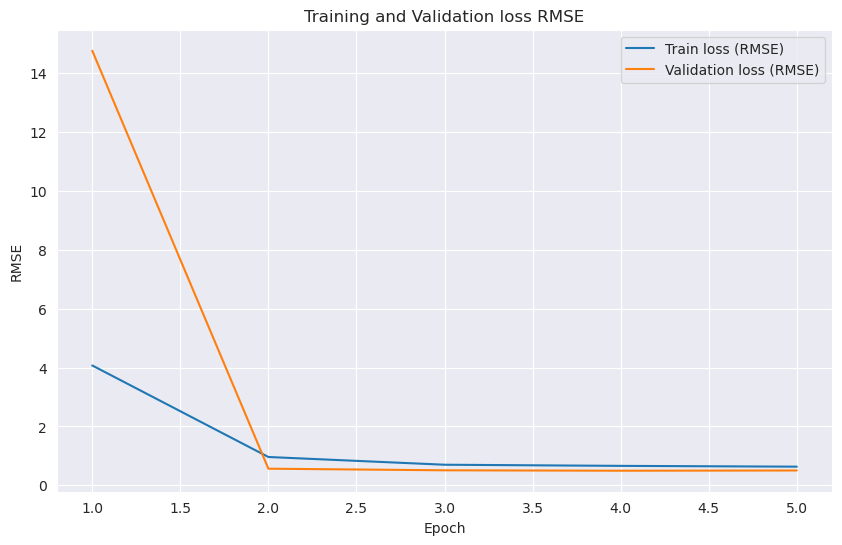

In [ ]:
plot_accuracy(train_loss_history, val_loss_history, 'RMSE')

#### Model test with single predictions

In [ ]:
def predict_score(user_id, item_id, model, user_mapping, item_mapping, device):
    # Convert user ID and item ID to their corresponding indices
    user_index = user_mapping[user_id]
    item_index = item_mapping[item_id]

    # Convert indices to tensors
    user_tensor = torch.tensor([user_index], dtype=torch.long).to(device)
    item_tensor = torch.tensor([item_index], dtype=torch.long).to(device)

    # Get the predicted score from the model
    with torch.no_grad():
        model.eval()
        score = model(user_tensor, item_tensor).item()

    return score

print(f'Predicted rating for user {user_id} and item {item_id}: {predict_score(user_id, 'B0006HXE1E', model, user_mapping, item_mapping, device)}')
# print(f'Actual rating: {user_product_matrix.loc[user_id, item_id]}')

TypeError: NCF.forward() missing 1 required positional argument: 'text_embeddings'

In [ ]:
unreviewed_products_df.head(2)

,description,title,brand,feature,rank,productPublishedDate,asin,main_cat_All Beauty,main_cat_All Electronics,main_cat_Amazon Home,"main_cat_Arts, Crafts & Sewing","main_cat_Arts, Crafts &amp; Sewing",main_cat_Automotive,main_cat_Baby,main_cat_Books,main_cat_Camera & Photo,main_cat_Camera &amp; Photo,main_cat_Car Electronics,main_cat_Cell Phones & Accessories,main_cat_Cell Phones &amp; Accessories,main_cat_Computers,main_cat_Gift Cards,main_cat_Grocery,main_cat_Health & Personal Care,main_cat_Home Audio & Theater,main_cat_Home Audio &amp; Theater,main_cat_Industrial & Scientific,main_cat_Industrial &amp; Scientific,main_cat_Musical Instruments,main_cat_Office Products,main_cat_Pet Supplies,main_cat_Portable Audio & Accessories,main_cat_Software,main_cat_Sports & Outdoors,main_cat_Sports &amp; Outdoors,main_cat_Tools & Home Improvement,main_cat_Tools &amp; Home Improvement,main_cat_Toys & Games,main_cat_Toys &amp; Games,main_cat_Video Games,dayDifferenceProduct
0,xclusive design classi,best abstract fiery floral design mouse pad cu...,luxladymousepad,material made best plastic manufacturing also ...,-1,"September 21, 1677",B00KH94VSG,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.059833
1,itten piano key mouse pad 8 x 8 x 25 made heav...,3drose llc 8 x 8 x 025 inch kitten piano key m...,3drose,dimension inch 8 w x 8 h x 025 matte finish so...,1,"July 14, 2014",B00CX71JNU,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0.848318
